# 模型评估（一）：参数选择

## Cross-validation: evaluating estimator performance

Learning the parameters of a prediction function and testing it on the same data is a methodological mistake: a model that would just repeat the labels of the samples that it has just seen would have a perfect score but would fail to predict anything useful on yet-unseen data. This situation is called overfitting. To avoid it, it is common practice when performing a (supervised) machine learning experiment to hold out part of the available data as a test set X_test, y_test. Note that the word “experiment” is not intended to denote academic use only, because even in commercial settings machine learning usually starts out experimentally.

In [ ]:
# Sklearn 0.18
sklearn.model_selection.train_test_split(*arrays, **options)

用test set来评估模型的指标是有缺陷的，会造成过拟合。如果用测试集来定制参数，就会矫枉过正。因为测试集能反映的只有一部分。我们希望能用更多的数据来定制参数。但我们只把数据集划分成了2份。两种方法，1. 把数据集划分为3份，再加一个验证集。2. 对训练集做一些小调整。

When evaluating different settings (“hyperparameters”) for estimators, such as the C setting that must be manually set for an SVM, there is still a risk of overfitting on the test set because the parameters can be tweaked（矫枉过正，调节过头了） until the estimator performs optimally. This way, knowledge about the test set can “leak” into the model and evaluation metrics no longer report on generalization performance. To solve this problem, yet another part of the dataset can be held out as a so-called “validation set”: training proceeds on the training set, after which evaluation is done on the validation set, and when the experiment seems to be successful, final evaluation can be done on the test set.

对于方法1，有缺陷。因为在数据有限的情况下，再划分为3份，无疑把数据量减少了。当数据量不足的时候，是很容易造成过拟合的。即使不会过拟合，也因为数据少，学到的东西少，模型的泛化性变差。所以我们一般是在训练集上下功夫，即方法2.把训练集划分为很多分，即划分为很多折（fold）。这就是最常用的cross validation.

However, by partitioning the available data into three sets, we drastically reduce the number of samples which can be used for learning the model, and the results can depend on a particular random choice for the pair of (train, validation) sets.
A solution to this problem is a procedure called cross-validation (CV for short). A test set should still be held out for final evaluation, but the validation set is no longer needed when doing CV. In the basic approach, called k-fold CV, the training set is split into k smaller sets (other approaches are described below, but generally follow the same principles). The following procedure is followed for each of the k “folds”:
   * A model is trained using k-1 of the folds as training data
   * the resulting model is validated on the remaining part of the data (i.e., it is used as a test set to compute a performance measure such      as accuracy).
   
The performance measure reported by k-fold cross-validation is then the average of the values computed in the loop. This approach can be computationally expensive, but does not waste too much data (as it is the case when fixing an arbitrary test set), which is a major advantage in problem such as inverse inference where the number of samples is very small.

### Computing cross-validated metrics

In [ ]:
sklearn.model_selection.cross_val_score(estimator, X, y=None, groups=None, scoring=None, cv=None, n_jobs=1, verbose=0, 
                                        fit_params=None, pre_dispatch='2*n_jobs')

参数：
1. estimator：模型。这个参数说明你要对什么模型进行评估。假设对logistic.
2. scoring：你要用什么指标来评估，比如f1,precision
3. cv：几折。一般5~10
4. n_jobs：是否并行。一般填-1.

In [3]:
# coding in here
# 先进行数据预处理
from sklearn.model_selection import cross_val_score
import pandas as pd

In [4]:
df =  pd.read_csv("adultTest.csv")

In [7]:
dfNew = pd.get_dummies(data = df, columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex','native-country'])

In [6]:
df.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
class             object
dtype: object

In [8]:
dfNew.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,class,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,39,77516,13,2174,0,40,<=50K,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,50,83311,13,0,0,13,<=50K,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,38,215646,9,0,0,40,<=50K,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,53,234721,7,0,0,40,<=50K,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,28,338409,13,0,0,40,<=50K,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# 把class中的空格去掉
dfNew['class'] = df['class'].map(lambda s : s.strip(" "))

In [12]:
dfNew.loc[dfNew['class'] == '<=50K', 'target'] = 0
dfNew.loc[dfNew['class'] != '<=50K', 'target'] = 1

In [13]:
dfNew.target.value_counts()

0.0    24720
1.0     7841
Name: target, dtype: int64

In [15]:
#去掉class这一列
dfNew.drop("class", axis=1, inplace = True)

In [17]:
X = dfNew.drop("target", axis = 1)
y = dfNew['target']

In [18]:
X.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,39,77516,13,2174,0,40,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,50,83311,13,0,0,13,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,38,215646,9,0,0,40,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,53,234721,7,0,0,40,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,28,338409,13,0,0,40,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
# 前期的数据处理完成了，开始建模
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(learning_rate=0.01, n_estimators=50, max_depth=2)
cross_val_score(gbc, X, y, cv=5, n_jobs=-1)

array([ 0.76708122,  0.76827396,  0.76765971,  0.76796683,  0.76858108])

In [24]:
# 换一下不同的参数看看效果
gbc = GradientBoostingClassifier(learning_rate=0.1, n_estimators=50, max_depth=4)
cross_val_score(gbc, X, y, cv=5, n_jobs=-1)
# 可以看到通过调整学习率和深度，准确率升高了

array([ 0.8601259 ,  0.85964373,  0.86517199,  0.86578624,  0.86701474])

#### 数据不平衡导致的cross validation数据划分的问题

通过`dfNew.target.value_counts()`，我们可以看到，数据是不平衡的。 那么如果我们使用k-fold来做cross validation的话，因为是随机划分，所以可能也会出现一份数据里全都是class为1的数据。

所以理想的状态是，我们是根据数据的y,即0，1的分布来划分的。争取每一次交叉验证的时候0和1的比例比较均衡的。所以这里就涉及到了一种分层的交叉。即下面的Stratified k-fold

### Cross validation iterators
1. K-fold：随机划分
2. Stratified k-fold：按比例划分
3. Label k-fold
4. Leave-One-Out - LOO
5. Leave-P-Out - LPO

cv : int, cross-validation generator or an iterable, optional
Determines the cross-validation splitting strategy. Possible inputs for cv are:

* None, to use the default 3-fold cross validation,
* integer, to specify the number of folds in a (Stratified)KFold,
* An object to be used as a cross-validation generator.
* An iterable yielding train, test splits. 这个就是下面的kf，就是一个迭代器

For integer/None inputs, if the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used. In all other cases, KFold is used.

In [28]:
import numpy as np
from sklearn.cross_validation import KFold

kf = KFold(4, n_folds=2) # 第一个参数说明有4个样本，第二个说明分为2折  
for train, test in kf:
    print("%s %s" % (train, test))

[2 3] [0 1]
[0 1] [2 3]


In [29]:
# 用迭代器来进行交叉验证
kf1 = KFold(len(X), n_folds=5)
gbc = GradientBoostingClassifier(learning_rate=0.1, n_estimators=50, max_depth=4)
cross_val_score(gbc, X, y, cv=kf1, n_jobs=-1)

array([ 0.86043298,  0.86148649,  0.86624693,  0.86624693,  0.86409705])

用下面分层的交叉验证来做菜比较符合我们这个数据集。但是在sklearn这个包里，基本都是默认分层交叉验证。不用我们再单独写一个下面那样的迭代器。

In [30]:
from sklearn.cross_validation import StratifiedKFold

labels = [0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
skf = StratifiedKFold(labels, 3)
for train, test in skf:
    print("%s %s" % (train, test))

[2 3 6 7 8 9] [0 1 4 5]
[0 1 3 4 5 8 9] [2 6 7]
[0 1 2 4 5 6 7] [3 8 9]


In [31]:
skf1 = StratifiedKFold(y, 5)

#### 3. Label k-fold
这个一般在多分类的时候用。如果y有3个值，类别，Label k-fold 会在train时只用两个类别，测试的时候用另外一个类别。保证你训练和测试时用的类别不一样。

#### 4. Leave-One-Out - LOO

之前的kfold比如是把数据划分成5份。比如样本有1000个，分为5组的话，4组用来train，1组用来test。
有一种非常极端的情况。1000个样本，我们就分为1000组，每一组都是拿999个来train,拿1个来test. 这其实就是KFold的特殊情况，即n_folds=样本数的时候，就是LOO。

这样做是很不好的，你得算1000个模型。先不说准确率，计算量就非常大了。

#### 5. Leave-P-Out - LPO
sklearn对上面的LOO做了一个改进，提示了LPO。比如我们leave 10个，20个，30个。比如拿980个样本train，20个样本做test。

### Random permutations cross-validation a.k.a. Shuffle & Split

这个小知识点介绍一下。当你拿到数据集的时候，不妨先将其打乱，让其具有随机性。

**ShuffleSplit**

The ShuffleSplit iterator will generate a user defined number of independent train / test dataset splits. Samples are first shuffled and then split into a pair of train and test sets.

It is possible to control the randomness for reproducibility of the results by explicitly seeding the random_state pseudo random number generator.


参数：
random_state如果你填10，第二次用的时候，随机得到的结果还是一样。同一个机器上10号种子是一样的。所以说调用函数的时候填入相同的random_state就会得到相同的数据。


In [ ]:
class sklearn.cross_validation.ShuffleSplit(n, n_iter=10, test_size=0.1, train_size=None, random_state=None)

In [34]:
# Coding in here .............
from sklearn.cross_validation import ShuffleSplit
ss = ShuffleSplit(len(X),test_size=0.3)
for train, test in ss:
    print (train)

[21019 10003  9297 ...,  1897  7716 23578]
[22846  4626  5059 ..., 21622  2251  8285]
[ 1106 29795  1330 ...,  2058 25065 30567]
[12168 21313   637 ..., 31621 28724 23770]
[ 1214 14073  3315 ...,  6496  5511 15500]
[ 9511 25615 21205 ...,  7949 23518  3365]
[17162  8561 25269 ...,  4032   816  9319]
[ 6785  4538  4820 ..., 13702 17419 16914]
[25738 19669 23083 ...,  6038 28581  4977]
[15951 28764 30362 ...,  7399 23317   828]


In [41]:
from sklearn.model_selection import ShuffleSplit
ss2 = ShuffleSplit(n_splits=3, test_size=0.3)
for train, test in ss2:
    print (train)

TypeError: 'ShuffleSplit' object is not iterable

**A note on shuffling**

如果数据里label 1的排在前面，label 0的排在后面，这样shuffle是有意义的。如果数据之间是有前后顺序的话，那么就不适合shuffle了。比如新闻数据就有较强的时间性。

If the data ordering is not arbitrary (e.g. samples with the same label are contiguous), shuffling it first may be essential to get a meaningful cross- validation result. However, the opposite may be true if the samples are not independently and identically distributed. For example, if samples correspond to news articles, and are ordered by their time of publication, then shuffling the data will likely lead to a model that is overfit and an inflated validation score: it will be tested on samples that are artificially similar (close in time) to training samples.

Some cross validation iterators, such as KFold, have an inbuilt option to shuffle the data indices before splitting them. Note that:

1. This consumes less memory than shuffling the data directly. cv相比shuffle消耗的资源比较少
2. By default no shuffling occurs, including for the (stratified) K fold cross- validation performed by specifying cv=some_integer to cross_val_score, grid search, etc. Keep in mind that train_test_split still returns a random split. CV默认是分层的fold，train_test_split返回的是随机分的结果，不是分层的结果。
3. The random_state parameter defaults to None, meaning that the shuffling will be different every time KFold(..., shuffle=True) is iterated. However, GridSearchCV will use the same shuffling for each set of parameters validated by a single call to its fit method. 用同一个数字可以得到同样的随机结果
4. To ensure results are repeatable (on the same platform), use a fixed value for random_state. 但是条件是必须在同一个机器上。

## Grid Search: Searching for estimator parameters



A search consists of:
1. an estimator (regressor or classifier such as sklearn.svm.SVC()); 分类器
2. a parameter space; 可能的参数，全部列出来
3. a method for searching or sampling candidates; 用什么指标来评估或抽样
4. a cross-validation scheme; 比如几折之类的
5. a score function. 评估的指标

**GridSearchCV exhaustively considers all parameter combinations **

把所有的参数都列出来，全部计算。

**RandomizedSearchCV can sample a given number of candidates from a parameter space with a specified distribution**

根据参数的分布来进行选择。比如让C符合0~1之间随机分布，训练的时候RandomizedSearchCV会随机挑选一个值来训练。这样的话训练出来的参数结果都是独立的。效率比GSCV高，因为不需要把所有组合跑一遍，随机选的话还是很快的。而且它不会影响模型表现，即泛化能力不会受影响。

所以说填写参数的时候要用下面两个scipy,numpy来指定分布。这是官网的例子
`{'C': scipy.stats.expon(scale=100), 'gamma': scipy.stats.expon(scale=.1), 'kernel': ['rbf'], 'class_weight':['balanced', None]}`

This example uses the scipy.stats module, which contains many useful distributions for sampling parameters, such as expon, gamma, uniform or randint. 

While using a grid of parameter settings is currently the most widely used method for parameter optimization, other search methods have more favourable properties. RandomizedSearchCV implements a randomized search over parameters, where each setting is sampled from a distribution over possible parameter values. This has two main benefits over an exhaustive search:
1. A budget can be chosen independent of the number of parameters and possible values.
2. Adding parameters that do not influence the performance does not decrease efficiency.

Specifying how parameters should be sampled is done using a dictionary, very similar to specifying parameters for GridSearchCV. Additionally, a computation budget, being the number of sampled candidates or sampling iterations, is specified using the n_iter parameter. For each parameter, either a distribution over possible values or a list of discrete choices (which will be sampled uniformly) can be specified

* scipy.stats

* numpy.random

In [ ]:
class sklearn.grid_search.GridSearchCV(estimator, param_grid, scoring=None, fit_params=None, n_jobs=1, iid=True, refit=True, cv=None, 
                                       verbose=0, pre_dispatch='2*n_jobs', error_score='raise')

参数：
param_grid：一个字典，存放可能的参数值。具体的值用list括起来。
scoring：用什么来评估
refit：如果为true，用最佳参数来训练模型。如果是false的话，还需要我们自己把这个参数提出来，重新训练一遍。 设置为true的话，直接就可以使用.predict，.score之类的函数。
error_score：有些参数设置是不合理的，会导致整个参数选择过程奔溃。设置成raise的话，如果出现这样的情况，就会报错（raise error)。强烈不建议用默认的，很容易会导致gridsearch出错。设为0即可。 

In [53]:
from sklearn.model_selection import GridSearchCV
clf = GradientBoostingClassifier()
param_grid = {'learning_rate':[0.001, 0.05], 'n_estimators':[50, 100], 'subsample':[0.7, 1.0]}
# 8 组参数组合
#cv = 5
#那么就是8*5=40组参数
gscv = GridSearchCV(clf, param_grid, n_jobs= -1, verbose=1, cv=5, error_score=0, scoring='roc_auc')

In [54]:
#开始训练
gscv.fit(X, y)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  2.7min finished


GridSearchCV(cv=5, error_score=0,
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'subsample': [0.7, 1.0], 'n_estimators': [50, 100], 'learning_rate': [0.001, 0.05]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

In [55]:
gscv.grid_scores_

/Users/xu/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.86682, std: 0.00174, params: {'subsample': 0.7, 'n_estimators': 50, 'learning_rate': 0.001},
 mean: 0.85991, std: 0.00464, params: {'subsample': 1.0, 'n_estimators': 50, 'learning_rate': 0.001},
 mean: 0.86567, std: 0.00147, params: {'subsample': 0.7, 'n_estimators': 100, 'learning_rate': 0.001},
 mean: 0.86212, std: 0.00298, params: {'subsample': 1.0, 'n_estimators': 100, 'learning_rate': 0.001},
 mean: 0.90747, std: 0.00346, params: {'subsample': 0.7, 'n_estimators': 50, 'learning_rate': 0.05},
 mean: 0.90715, std: 0.00311, params: {'subsample': 1.0, 'n_estimators': 50, 'learning_rate': 0.05},
 mean: 0.91494, std: 0.00308, params: {'subsample': 0.7, 'n_estimators': 100, 'learning_rate': 0.05},
 mean: 0.91453, std: 0.00300, params: {'subsample': 1.0, 'n_estimators': 100, 'learning_rate': 0.05}]

In [56]:
gscv.best_params_

{'learning_rate': 0.05, 'n_estimators': 100, 'subsample': 0.7}

In [57]:
gscv.predict_proba(X)

array([[ 0.89728284,  0.10271716],
       [ 0.54710326,  0.45289674],
       [ 0.95107369,  0.04892631],
       ..., 
       [ 0.95020558,  0.04979442],
       [ 0.98016983,  0.01983017],
       [ 0.05911325,  0.94088675]])

In [ ]:
class sklearn.grid_search.RandomizedSearchCV(estimator, param_distributions, n_iter=10, scoring=None, fit_params=None, n_jobs=1, 
                                             iid=True, refit=True, cv=None, verbose=0, pre_dispatch='2*n_jobs', random_state=None, 
                                             error_score='raise')

[Comparing randomized search and grid search for hyperparameter estimation](http://scikit-learn.org/0.17/auto_examples/model_selection/randomized_search.html#example-model-selection-randomized-search-py)

#### Tips
1. Specifying an objective metric. 用什么来评估是很重要的
2. Model selection: development and evaluation  在用gridseach的时候就做完了模型选择，参数选择。全
3. Parallelism 并行，不设置-1的话太慢了
4. Robustness to failure  不要用raise,整个系统瘫痪了。

#### Model specific cross-validation
1. linear_model.ElasticNetCV([l1_ratio, eps, ...])	Elastic Net model with iterative fitting along a regularization path
2. linear_model.LarsCV([fit_intercept, ...])	Cross-validated Least Angle Regression model
3. linear_model.LassoCV([eps, n_alphas, ...])	Lasso linear model with iterative fitting along a regularization path
4. linear_model.LassoLarsCV([fit_intercept, ...])	Cross-validated Lasso, using the LARS algorithm
5. linear_model.LogisticRegressionCV([Cs, ...])	Logistic Regression CV (aka logit, MaxEnt) classifier.
6. linear_model.MultiTaskElasticNetCV([...])	Multi-task L1/L2 ElasticNet with built-in cross-validation.
7. linear_model.MultiTaskLassoCV([eps, ...])	Multi-task L1/L2 Lasso with built-in cross-validation.
8. linear_model.OrthogonalMatchingPursuitCV([...])	Cross-validated Orthogonal Matching Pursuit model (OMP)
9. linear_model.RidgeCV([alphas, ...])	Ridge regression with built-in cross-validation.
10. linear_model.RidgeClassifierCV([alphas, ...])	Ridge classifier with built-in cross-validation.

#### Out of Bag Estimates

集成方法是用抽样的，所以说总有一部分数据没有进模型。这和把数据集划分成训练集和测试集的思想是一样的。所以说根本就不需要CV，直接将OOB的值拿出来就行了。拿下面第5个来做例子，如何查看OOB值。

1. ensemble.RandomForestClassifier([...])	A random forest classifier.
2. ensemble.RandomForestRegressor([...])	A random forest regressor.
3. ensemble.ExtraTreesClassifier([...])	An extra-trees classifier.
4. ensemble.ExtraTreesRegressor([n_estimators, ...])	An extra-trees regressor.
5. ensemble.GradientBoostingClassifier([loss, ...])	Gradient Boosting for classification.
6. ensemble.GradientBoostingRegressor([loss, ...])	Gradient Boosting for regression.

In [58]:
clf = GradientBoostingClassifier()
clf.fit(X, y)
# 训练完后想查看OOB的值。帮助文档里有，但是实际用的时候没有。想都不听想，这是bug

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [65]:
clf.oob_improvement_

AttributeError: 'GradientBoostingClassifier' object has no attribute 'oob_improvement_'

In [63]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(oob_score= True)
rf.fit(X,y)

/Users/xu/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=True, random_state=None,
            verbose=0, warm_start=False)

In [64]:
rf.oob_score_
# 这个返回的结果是precision

0.83418813918491452

# 模型评估（二）

## Model evaluation: quantifying the quality of predictions

分类模型的评估指标。另外log_loss是用来衡量多分类的分类效果的

之前说准确率（accuracy）这个指标不好，原因在于数据不平衡的时候，准确率是失准的，无效的，无法刻画模型的效果。那为什么准确率会失效呢？

因为对于不平衡的数据，如果全部预测为0，正确率也有95%，但是标签为1的样本一个也没检测出来，而我们关注的反而是那些较少的样本，所以说即使准确率高，这样的模型对项目来说也毫无意义。

所以我们引入了recall和precision。我们希望这两个越大越好。但这两个是相互制衡的。所以引入F1值。在官网的F1里
```
sklearn.metrics.f1_score(y_true, y_pred, labels=None, pos_label=1, average='binary', sample_weight=None)
```
其中`average : string, [None, ‘binary’ (default), ‘micro’, ‘macro’, ‘samples’, ‘weighted’]`。micro：微观的F1值。macro：宏观的F1值。比如说你用的是集成模型，建了100个模型，每棵树都有一个混淆矩阵，那么怎么计算最终的那个混淆矩阵呢？或者说怎么计算最终的F1值。micro就是把每一个混淆矩阵里对应的数字累计起来，做一个平均数，得到一个将100个模型平均后的混淆矩阵。macro，每一个混淆矩阵都计算好F1值，最后再求F1值的平均就可以了。

### 下面是三种用途

1. Estimator score method. 
2. Scoring parameter
3. Metric functions

#### [The scoring parameter: defining model evaluation rules](http://scikit-learn.org/0.17/modules/model_evaluation.html)

#### [Classification metrics](http://scikit-learn.org/0.17/modules/model_evaluation.html)
![precision](http://scikit-learn.org/0.17/_images/math/f8029f7b6c8fc80db737d850ed8e10ea8f27e410.png)
![recall](http://scikit-learn.org/0.17/_images/math/ca017d3d38a5a935ae8bee84d8143b44f1b32c9a.png)
![F](http://scikit-learn.org/0.17/_images/math/b6183c8fb10498f949131f2aa67eeb1256cdc68a.png)

### ROC

下面的图里面积是0.79. 一般来说下方的面积是越大越好。如果连0.5都不到，那么你的模型是严重的欠拟合。如果你是0.98，0.99.基本上是出现了过拟合。一般0.92~0.95之前比较合理。

所以我们一般用F1和ROC来评估模型，希望这两个越大越好。

![roc](http://scikit-learn.org/0.17/_images/plot_roc_0011.png)

In [66]:
from sklearn.model_selection import GridSearchCV
clf = GradientBoostingClassifier()
param_grid = {'learning_rate':[0.001, 0.05], 'n_estimators':[50, 100], 'subsample':[0.7, 1.0]}
gscv = GridSearchCV(clf, param_grid, n_jobs= -1, verbose=1, cv=5, error_score=0, scoring='f1')

In [67]:
gscv.fit(X,y)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/Users/xu/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/xu/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/xu/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/xu/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/xu/anaconda/envs/py35/lib/pyt

GridSearchCV(cv=5, error_score=0,
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'subsample': [0.7, 1.0], 'n_estimators': [50, 100], 'learning_rate': [0.001, 0.05]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=1)

In [69]:
pred_proba = gscv.predict_proba(X)

In [70]:
proba = pred_proba[:,1]

In [71]:
from sklearn.metrics import precision_recall_curve
precision, recall, thre = precision_recall_curve(y, proba)

In [77]:
print (precision.shape)
print (precision)
print (recall.shape)
print (recall)
print (thre.shape)
# 发现收一个数字
print (thre)

(12284,)
[ 0.24807011  0.25067144  0.25068747 ...,  1.          1.          1.        ]
(12284,)
[  1.00000000e+00   9.99872465e-01   9.99872465e-01 ...,   2.55069506e-04
   1.27534753e-04   0.00000000e+00]
(12283,)
[ 0.02057892  0.02060187  0.0206251  ...,  0.96567062  0.96614831
  0.96701057]


In [ ]:
sklearn.metrics.precision_recall_curve(y_true, probas_pred, pos_label=None, sample_weight=None)

参数：
y_true：就是（X,y)里的y。
probas_pred：输入的是概率值

返回的是三个数组,precision, recall, thresholds.
我们的模型是对每一个样本打一个分数，那这个分数什么时候能决定一个样本是0，或是1呢？于是我们需要阈值。默认情况下，这个阈值就是0.5，即如果一个样本的分数大于0.5，那么久预测为1，反之预测为0.所以说，我们的混淆矩阵是阈值在0.5的时候绘制出来的。 如果设置阈值为0.8，那么预测标签为1的样本会减少，对应的混淆矩阵也会变化。直接影响precision和recall。所以说precision, recall, thresholds这三个是紧密相关的。

In [79]:
import matplotlib.pyplot as plt
%matplotlib inline

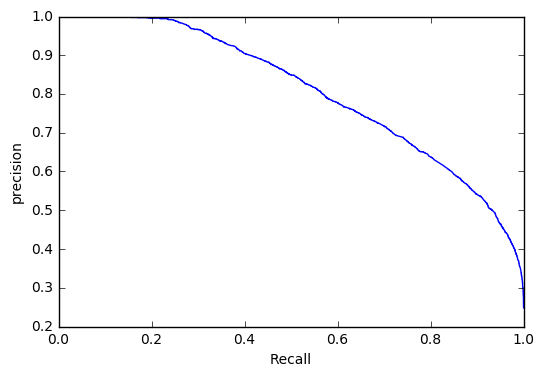

In [81]:
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("precision")

阈值越高，recall越小。就是说我条件变得苛刻，但是准确率会很高。

In [ ]:
sklearn.metrics.roc_curve(y_true, y_score, pos_label=None, sample_weight=None, drop_intermediate=True)
# 这个很少用到

In [82]:
from sklearn.metrics import roc_curve
roc_curve(y, proba)

(array([ 0.        ,  0.        ,  0.        , ...,  0.99967638,
         0.99971683,  1.        ]),
 array([  1.27534753e-04,   5.61152914e-03,   6.37673766e-03, ...,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00]),
 array([ 0.96701057,  0.95328213,  0.95256697, ...,  0.01778968,
         0.01753773,  0.01749676]))

In [83]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y, proba)

0.91811209149153328

In [ ]:
sklearn.metrics.confusion_matrix(y_true, y_pred, labels=None)
# label是横轴还是纵轴
# y_pred不是概率值，而是预测值

In [ ]:
sklearn.metrics.classification_report(y_true, y_pred, labels=None, target_names=None, sample_weight=None, digits=2)[source]

In [84]:
from sklearn.metrics import classification_report
print (classification_report(y, gscv.predict(X)))

             precision    recall  f1-score   support

        0.0       0.88      0.95      0.91     24720
        1.0       0.80      0.57      0.67      7841

avg / total       0.86      0.86      0.85     32561



In [ ]:
sklearn.metrics.f1_score(y_true, y_pred, labels=None, pos_label=1, average='binary', sample_weight=None)[source]

In [ ]:
sklearn.metrics.fbeta_score(y_true, y_pred, beta, labels=None, pos_label=1, average='binary', sample_weight=None)
# The beta parameter determines the weight of precision in the combined score. beta < 1 lends more weight to precision, 
# while beta > 1 favors recall (beta -> 0 considers only precision, beta -> inf only recall).

虽然我们希望recall和precision和变大，但是模型总有偏向的一方。beta是用来调整这个权重的。比如beta越大，越关注recall，beta越小，越关注precision

In [86]:
from sklearn.metrics import fbeta_score
fbeta_score(y, gscv.predict(X), beta=0.5)

0.73882197657152293